In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
from tqdm import tqdm # Progress bar

In [2]:
import os
import pandas as pd 

root_dir = './Images/' # Insert your data here
sub_folders = ["no_shoes", "shoes"] # Insert your classes here
labels = [0, 1]

data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        print(r,d,f)
        for file in f:
            if ".jpg" or ".JPG" in file:
                
                data.append((os.path.join(s,file), l))

df = pd.DataFrame(data, columns=['file_name','label'])
df
# print(os.path)

./Images/no_shoes [] ['IMG_3988.jpg', 'IMG_3989.jpg', 'IMG_4038.JPG', 'IMG_4054.JPG', 'IMG_4053.JPG', 'IMG_4055.JPG', 'IMG_3990.jpg', 'IMG_3991.jpg', 'IMG_4015.jpg', 'IMG_4037.JPG', 'IMG_4036.JPG', 'IMG_4016.jpg', 'IMG_4035.JPG', 'IMG_4014.jpg', 'IMG_4052.JPG', 'IMG_4013.jpg']
./Images/shoes [] ['IMG_3981.jpg', 'IMG_4027.JPG', 'IMG_4026.JPG', 'IMG_3967.jpg', 'IMG_4034.JPG', 'IMG_3982.jpg', 'IMG_4033.JPG', 'IMG_3971.jpg', 'IMG_3962.jpg', 'IMG_4024.JPG', 'IMG_3999.jpg', 'IMG_3986.jpg', 'IMG_4004.jpg', 'IMG_4003.jpg', 'IMG_3980.jpg', 'IMG_4010.jpg', 'IMG_4012.jpg', 'IMG_3987.jpg', 'IMG_3966.jpg', 'IMG_4017.JPG', 'IMG_4011.jpg', 'IMG_4025.JPG', 'IMG_4001.jpg', 'IMG_3978.jpg', 'IMG_3983.jpg', 'IMG_4050.JPG', 'IMG_4049.JPG', 'IMG_4023.JPG', 'IMG_3996.jpg', 'IMG_4002.jpg', 'IMG_4009.jpg', 'IMG_3969.jpg', 'IMG_4018.JPG', 'IMG_3984.jpg', 'IMG_4043.JPG', 'IMG_4031.JPG', 'IMG_4007.jpg', 'IMG_4046.JPG', 'IMG_4022.JPG', 'IMG_3994.jpg', 'IMG_3974.jpg', 'IMG_4051.JPG', 'IMG_4032.JPG', 'IMG_4040.JPG',

,file_name,label
0,no_shoes/IMG_3988.jpg,0
1,no_shoes/IMG_3989.jpg,0
2,no_shoes/IMG_4038.JPG,0
3,no_shoes/IMG_4054.JPG,0
4,no_shoes/IMG_4053.JPG,0
...,...,...
83,shoes/IMG_3973.jpg,1
84,shoes/IMG_3992.jpg,1
85,shoes/IMG_3993.jpg,1
86,shoes/IMG_3995.jpg,1


<Axes: xlabel='label', ylabel='count'>

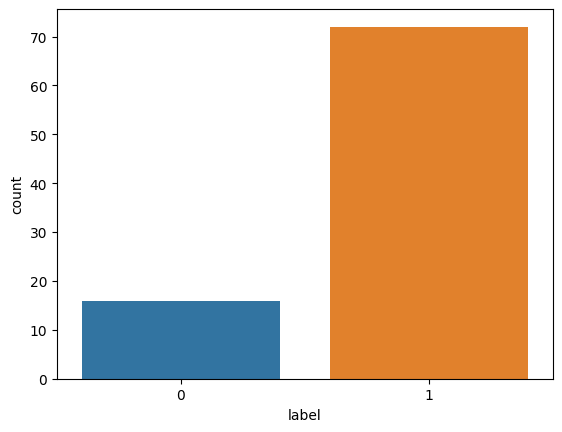

In [3]:
import seaborn as sns
sns.countplot(data = df, x = 'label')

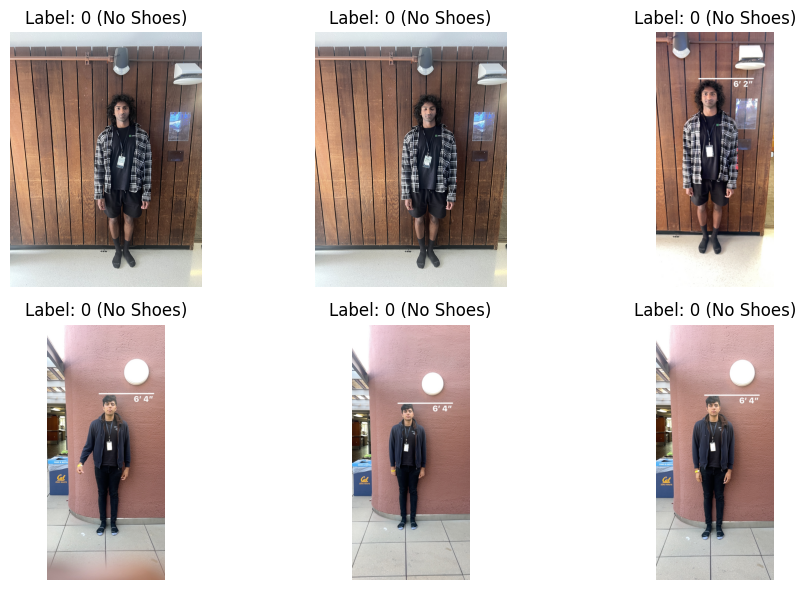

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 0
for i in range(2):
    for j in range(3):
        
        label = df.label[idx]
        file_path = os.path.join(root_dir, df.file_name[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image
        # image = image[1500:, 1854:]
        # image = cv2.resize(image, (256, 256))
        
        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({'Shoes' if label == 1 else 'No Shoes'})")
        ax[i,j].axis('off')
        idx = idx+1
        
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, 
                                      test_size = 0.1, 
                                      random_state = 42)

In [6]:
train_df.head()

,file_name,label
68,shoes/IMG_3976.jpg,1
85,shoes/IMG_3993.jpg,1
65,shoes/IMG_3985.jpg,1
53,shoes/IMG_4046.JPG,1
80,shoes/IMG_4029.JPG,1


In [7]:
test_df.head()

,file_name,label
76,shoes/IMG_3997.jpg,1
0,no_shoes/IMG_3988.jpg,0
26,shoes/IMG_3999.jpg,1
22,shoes/IMG_4033.JPG,1
12,no_shoes/IMG_4035.JPG,0


In [8]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [14]:
# TEMPLATE FOR CUSTOM DATASET
# class CustomDataset(Dataset):
#     def __init__(self, df):
#         # Initialize anything you need later here ...
#         self.df = df
#         self.X = ...
#         self.y = ...
#         # ...
 
#     # Get the number of rows in the dataset
#     def __len__(self):
#         return len(self.df)
 
#     # Get a sample of the dataset
#     def __getitem__(self, idx):
#         return [self.X[idx], self.y[idx]]

In [9]:
cfg.root_dir = './Images/' # Insert your data here
cfg.image_size = 1024

class CustomDataset(Dataset):
    def __init__(self, 
                 cfg, 
                 df, 
                 transform=None, 
                mode = "val"):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = df['label'].values

        if transform:
          self.transform = transform
        else:
          self.transform = A.Compose([
                              A.Resize(cfg.image_size, cfg.image_size), 
                              ToTensorV2(),
                           ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations        
        augmented = self.transform(image=image)
        image = augmented['image']
            
        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255
            
        return image, label

In [10]:
cfg.batch_size = 32

example_dataset = CustomDataset(cfg, df)

example_dataloader = DataLoader(example_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers=0,
                             )

In [11]:
for (image_batch, label_batch) in example_dataloader:
    print(image_batch.shape)
    print(label_batch.shape)
    break

torch.Size([32, 3, 1024, 1024])
torch.Size([32])


In [12]:
torch.Size([32, 3, 1024, 1024])
torch.Size([32])

torch.Size([32])

In [13]:
X = df
y = df.label

train_df, valid_df, y_train, y_test = train_test_split(X, 
                                                       y, 
                                                       test_size = 0.2, 
                                                       random_state = 42)

In [14]:
train_dataset = CustomDataset(cfg, train_df)
valid_dataset = CustomDataset(cfg, valid_df)

train_dataloader = DataLoader(train_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = False)

In [15]:
import timm

cfg.n_classes = 2
cfg.backbone = 'resnet18'

model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

In [16]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)

In [17]:
criterion = nn.CrossEntropyLoss()


In [18]:
cfg.learning_rate = 1e-4

optimizer = torch.optim.Adam(
  model.parameters(), 
  lr = cfg.learning_rate, 
  weight_decay = 0,
 )

In [19]:
cfg.lr_min = 1e-5
cfg.epochs = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
  optimizer, 
  T_max = np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
  eta_min = cfg.lr_min
)

In [20]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

In [21]:
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()
    
    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)
            
            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()
            
            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()
                               
        scheduler.step()
        
    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss

In [22]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()
    
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)  

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()
            
            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss

In [23]:
from sklearn.model_selection import StratifiedKFold

cfg.n_folds = 5

# Create a new column for cross-validation folds
df["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=cfg.n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df, y = df.label)):
      df.loc[val_ , "kfold"] = fold
        
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

In [24]:
transform_soft = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-45,45]),
                             A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 64, max_width = 64, p=0.3),
                             ToTensorV2()])

In [25]:
import random

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    # In general seed PyTorch operations
    torch.manual_seed(seed)
    
    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)
    
    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)
    
    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True 
    
    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

In [26]:
cfg.seed = 42

def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")
        
        set_seed(cfg.seed + epoch)
        
        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)
        
        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)
        
        print(f'Loss: {loss:.4f} Acc: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)
        
        if valid_dataloader:
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
    
    return acc_list, loss_list, val_acc_list, val_loss_list, model

In [27]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')
    
    ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

Epoch 1/5


100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


Loss: 0.6079 Acc: 0.8286
Val Loss: 0.6628 Val Acc: 0.7222
Epoch 2/5


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Loss: 0.5616 Acc: 0.8286
Val Loss: 0.6419 Val Acc: 0.7778
Epoch 3/5


100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Loss: 0.5574 Acc: 0.8286
Val Loss: 0.6245 Val Acc: 0.7778
Epoch 4/5


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Loss: 0.5273 Acc: 0.8286
Val Loss: 0.6131 Val Acc: 0.7778
Epoch 5/5


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Loss: 0.5122 Acc: 0.8286
Val Loss: 0.6020 Val Acc: 0.7778


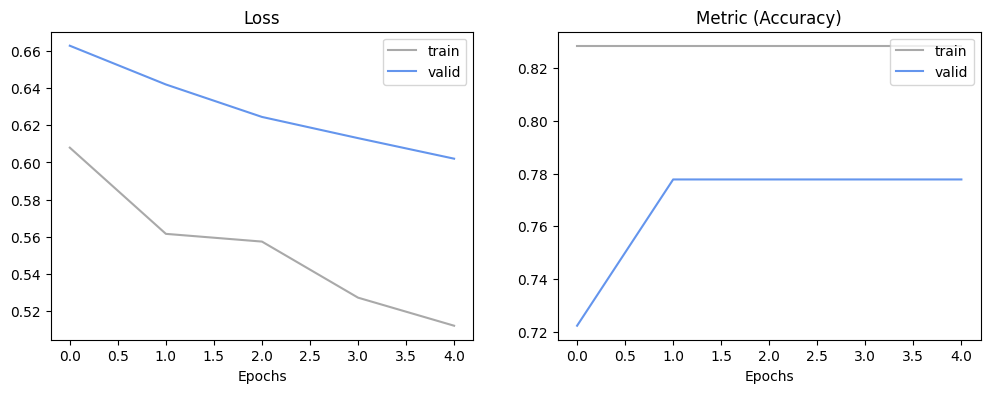

Epoch 1/5


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Loss: 0.7297 Acc: 0.2000
Val Loss: 0.7337 Val Acc: 0.1667
Epoch 2/5


100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Loss: 0.6936 Acc: 0.4714
Val Loss: 0.7050 Val Acc: 0.6111
Epoch 3/5


100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


Loss: 0.6666 Acc: 0.7143
Val Loss: 0.6849 Val Acc: 0.5556
Epoch 4/5


100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Loss: 0.6458 Acc: 0.8143
Val Loss: 0.6761 Val Acc: 0.5556
Epoch 5/5


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Loss: 0.6397 Acc: 0.7857
Val Loss: 0.6695 Val Acc: 0.6111


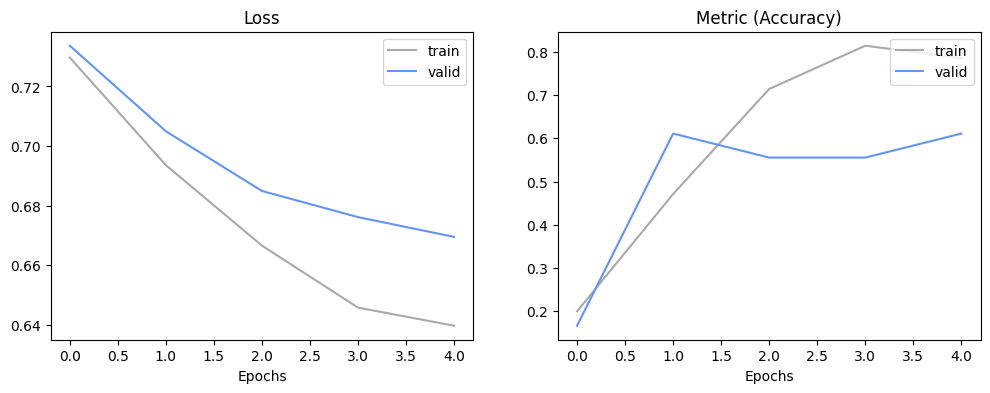

Epoch 1/5


100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


Loss: 0.7283 Acc: 0.2000
Val Loss: 0.7247 Val Acc: 0.1667
Epoch 2/5


100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Loss: 0.6901 Acc: 0.5571
Val Loss: 0.6974 Val Acc: 0.5556
Epoch 3/5


100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Loss: 0.6618 Acc: 0.6857
Val Loss: 0.6819 Val Acc: 0.6667
Epoch 4/5


100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


Loss: 0.6439 Acc: 0.8286
Val Loss: 0.6716 Val Acc: 0.6667
Epoch 5/5


100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Loss: 0.6353 Acc: 0.8000
Val Loss: 0.6669 Val Acc: 0.6667


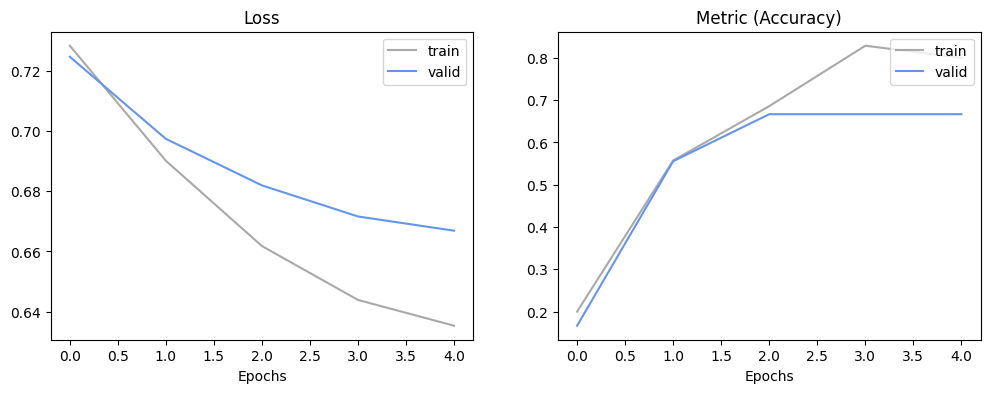

Epoch 1/5


100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


Loss: 0.7269 Acc: 0.1972
Val Loss: 0.7132 Val Acc: 0.1765
Epoch 2/5


100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


Loss: 0.6841 Acc: 0.6197
Val Loss: 0.6879 Val Acc: 0.7059
Epoch 3/5


100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


Loss: 0.6607 Acc: 0.7183
Val Loss: 0.6709 Val Acc: 0.7059
Epoch 4/5


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


Loss: 0.6410 Acc: 0.7746
Val Loss: 0.6621 Val Acc: 0.7059
Epoch 5/5


100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


Loss: 0.6374 Acc: 0.7746
Val Loss: 0.6560 Val Acc: 0.7059


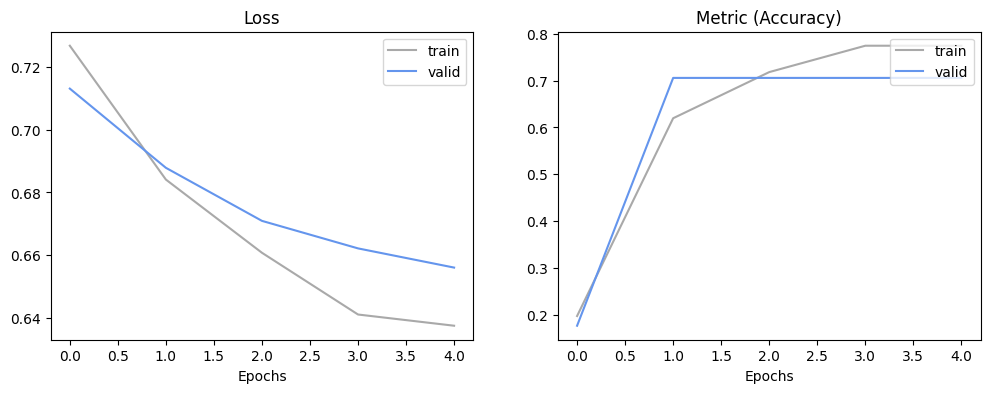

Epoch 1/5


100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


Loss: 0.7280 Acc: 0.1831
Val Loss: 0.7077 Val Acc: 0.2353
Epoch 2/5


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Loss: 0.6896 Acc: 0.5352
Val Loss: 0.6811 Val Acc: 0.7647
Epoch 3/5


100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


Loss: 0.6620 Acc: 0.7183
Val Loss: 0.6618 Val Acc: 0.7647
Epoch 4/5


100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


Loss: 0.6450 Acc: 0.7465
Val Loss: 0.6491 Val Acc: 0.8235
Epoch 5/5


100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Loss: 0.6420 Acc: 0.7746
Val Loss: 0.6424 Val Acc: 0.8235


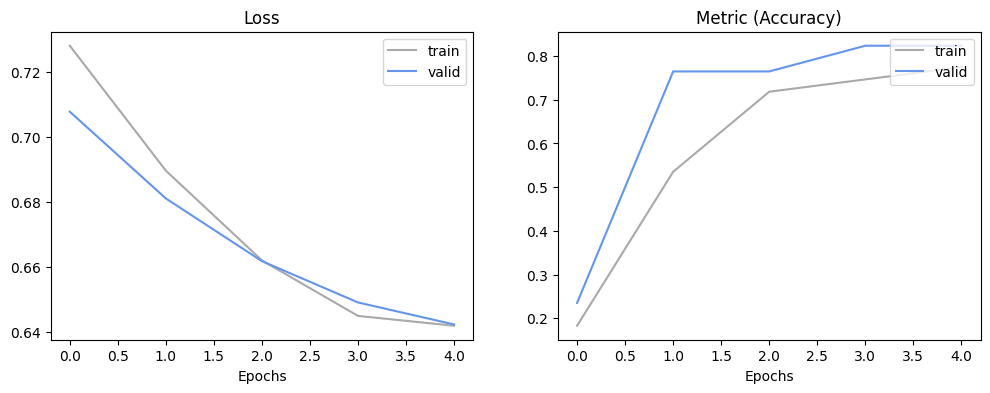

 33%|███▎      | 1/3 [00:46<01:33, 46.87s/it]


KeyboardInterrupt: 

In [28]:
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)
    valid_dataset = CustomDataset(cfg, valid_df)

    train_dataloader = DataLoader(train_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers = 0,
                             )
    valid_dataloader = DataLoader(valid_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = False, 
                              num_workers = 0,
                             )
    
    model = timm.create_model(cfg.backbone, 
                              pretrained = True, 
                              num_classes = cfg.n_classes)
    
    model = model.to(cfg.device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = cfg.learning_rate, 
                                 weight_decay = 0,
                                )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                           T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                           eta_min=cfg.lr_min)

    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader)
    
    visualize_history(acc, loss, val_acc, val_loss)

In [68]:
train_df = df.copy()

train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)

train_dataloader = DataLoader(train_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = True, 
                          num_workers = 0,
                         )

In [69]:
model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

model = model.to(cfg.device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr = cfg.learning_rate, 
                             weight_decay = 0,
                            )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                       eta_min=cfg.lr_min)

acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, cfg, train_dataloader)

Epoch 1/5


100%|██████████| 3/3 [00:43<00:00, 14.54s/it]


Loss: 0.7265 Acc: 0.2273
Epoch 2/5


100%|██████████| 3/3 [00:43<00:00, 14.65s/it]


Loss: 0.6910 Acc: 0.4545
Epoch 3/5


100%|██████████| 3/3 [00:44<00:00, 14.86s/it]


Loss: 0.6646 Acc: 0.7386
Epoch 4/5


100%|██████████| 3/3 [00:43<00:00, 14.46s/it]


Loss: 0.6493 Acc: 0.7500
Epoch 5/5


100%|██████████| 3/3 [00:44<00:00, 14.69s/it]

Loss: 0.6457 Acc: 0.8068


In [37]:
test_dataset = CustomDataset(cfg, test_df)

test_dataloader = DataLoader(test_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = False, 
                          num_workers = 0,
                         )

dataloader = test_dataloader

# Validation mode
model.eval()

final_y = []
final_y_pred = []

# Iterate over data
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    X = batch[0].to(cfg.device)
    y = batch[1].to(cfg.device)
    print(type(X))
    print(X)

    with torch.no_grad():
        # Forward: Get model outputs
        y_pred = model(X)

        # Covert y and y_pred to lists
        y =  y.detach().cpu().numpy().tolist()
        y_pred =  y_pred.detach().cpu().numpy().tolist()

        # Extend original list
        final_y.extend(y)
        final_y_pred.extend(y_pred)

# Calculate statistics
final_y_pred_argmax = np.argmax(final_y_pred, axis=1)
metric = calculate_metric(final_y, final_y_pred_argmax)

test_df['prediction'] = final_y_pred_argmax

  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
tensor([[[[0.7451, 0.7333, 0.7490,  ..., 0.6275, 0.6353, 0.5451],
          [0.7333, 0.7490, 0.7412,  ..., 0.6824, 0.6235, 0.5451],
          [0.7373, 0.7373, 0.7451,  ..., 0.6078, 0.6471, 0.5882],
          ...,
          [0.8745, 0.8863, 0.7686,  ..., 0.6471, 0.6392, 0.7490],
          [0.8863, 0.8078, 0.6157,  ..., 0.6353, 0.6510, 0.6902],
          [0.7922, 0.6510, 0.6275,  ..., 0.6275, 0.6627, 0.6471]],

         [[0.7686, 0.7529, 0.7725,  ..., 0.5137, 0.5216, 0.4314],
          [0.7569, 0.7725, 0.7647,  ..., 0.5686, 0.5098, 0.4314],
          [0.7608, 0.7608, 0.7686,  ..., 0.4941, 0.5333, 0.4745],
          ...,
          [0.8784, 0.8902, 0.7725,  ..., 0.6471, 0.6392, 0.7490],
          [0.8902, 0.8118, 0.6196,  ..., 0.6353, 0.6510, 0.6902],
          [0.7961, 0.6549, 0.6314,  ..., 0.6275, 0.6627, 0.6471]],

         [[0.7686, 0.7529, 0.7725,  ..., 0.5216, 0.5294, 0.4392],
          [0.7569, 0.7725, 0.7647,  ..., 0.5765, 0.5176, 0.4353],
          [0.7608, 

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


In [40]:
from torchvision import transforms
from PIL import Image

convert_tensor = transforms.ToTensor()

img_tensor = convert_tensor(Image.open('./Images/no_shoes/IMG_3988.jpg'))

transform = transforms.toTensorV2()

img_tensor = transform(img_tensor)

model(img_tensor)



AttributeError: module 'torchvision.transforms' has no attribute 'toTensorV2'

In [1]:
print(model)

NameError: name 'model' is not defined